# Generate word networks enriched with party information

Import the basic stuff.

In [114]:
import json
import requests
from collections import Counter
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load the preprocessed data.

In [160]:
with open('../data/speeches_preprocessed.json', 'r') as fp:
    data = json.load(fp)

In [116]:
reden = data.copy()

This step of data cleaning can be skipped soon.

In [117]:
# clean party labels
for rede in reden:
    rede['party']=rede['party'].replace(u'\xa0', u' ')
    if rede['party']=='Bündnis 90/Die Grünen':
        rede['party']='BÜNDNIS 90/DIE GRÜNEN'
    if rede['party']=='Fraktionslos':
        rede['party']='fraktionslos'

### Data selection

Now select, if desired, a subset of speeches by party, parlamentarians, date, etc. Note that it does not work for the 'text'-field, but 'text_lem' should work.

To be checked.

In [ ]:

def filter_for(what, search_terms, speeches):
    filtered_speeches = []
    for speech in speeches:
        if ( set(search_terms) & set(speech[what]) ) == set():
            filtered_speeches.append(speech)
    filtered_speeches.sort(key = lambda x:x['date']) 
    return filtered_speeches


## Build corpus and count word frequencoies per party

In [121]:
corpus = []
allwords = []

# prepare for per party counts
allwordsperparty = {
    'SPD':[],
    'FDP':[],
    'CDU/CSU':[],
    'DIE LINKE':[],
    'BÜNDNIS 90/DIE GRÜNEN':[],
    'AfD':[],
    'fraktionslos':[],
    'Bremen':[]   
}
        
#consider = ['PROPN']
#consider = ['ADJ']
consider = ['NOUN']
for rede in tqdm.tqdm(reden):
    #if(len(rede['text']) > 1000):
    #rel_lemmata = [ ele for ex,ele in enumerate(rede['text_lem']) if (rede['text_pos'][ex] in consider and len(ele) > 7 and len(ele) < 16)]
    rel_lemmata = [ ele for ex,ele in enumerate(rede['text_lem']) if rede['text_pos'][ex] in consider ]
    allwords.extend(rel_lemmata)
    allwordsperparty[rede['party']].extend(rel_lemmata)
    corpus.append( " ".join(rel_lemmata ))
    

100%|██████████| 24666/24666 [00:02<00:00, 10993.59it/s]


## Select words by frequency in corpus

In [127]:
features02=[]
#word_counter= Counter(x for xs in corpus for x in xs)
word_counter = Counter(allwords)
for word in word_counter.keys():
    if word_counter[word] > 40 and word_counter[word] < 10000:
        features02.append(word)

#print(word_counter)
#Counter(corpus)
len(features02)

5787

In [123]:
len(set(allwordsperparty['SPD']))

52979

## Count word frequencies per speech

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer01 = CountVectorizer( decode_error='ignore' , lowercase=False , max_df=0.3, min_df=2/len(corpus),max_features=1000)
#vectorizer01 = CountVectorizer( decode_error='ignore' , lowercase=False , max_df=0.3, min_df=2, ngram_range=(1, 1))
vectorizer01 = CountVectorizer(vocabulary = features02, decode_error='ignore' , lowercase=False , max_df=0.3, min_df=2, ngram_range=(1, 1))
X01 = vectorizer01.fit_transform(corpus)
features01 = vectorizer01.get_feature_names()

print(f'We now consider {len(features02)} different words.')
#print(features01)

We now consider 5787 different words.


In [129]:
X01T = X01.T
X01T.get_shape()

(5787, 24666)

## Cosine similarity

In [131]:
from sklearn.metrics.pairwise import cosine_similarity
SIMT01 = cosine_similarity(X01T)

In [132]:
SIMT01.shape

(5787, 5787)

## Count words per party

In [135]:
counts_per_party = {}

for party in allwordsperparty.keys():
    counts_per_party.update({ party : Counter(allwordsperparty[party])  })

#counts_per_party = {
#    'SPD': Counter(allwordsperparty['SPD']),
#    'FDP':Counter(allwordsperparty['FDP']),
#    'CDU/CSU':[],
#    'DIE LINKE':[],
#    'BÜNDNIS 90/DIE GRÜNEN':[],
#    'AfD':[],
#    'fraktionslos':[],
#    'Bremen':[]   
#}


## Construct Graph

In [150]:
nodes = []
for wx,word in enumerate(features01):
    node = {
        'id' : wx,
        'name' : word,
        'cALL' : word_counter[word]/len(word_counter),
        'cSPD' : counts_per_party['SPD'][word]/len(counts_per_party['SPD']),
        'cFDP' : counts_per_party['FDP'][word]/len(counts_per_party['FDP']),
        'cCDU' : counts_per_party['CDU/CSU'][word]/len(counts_per_party['CDU/CSU']),
        'cLINKE' : counts_per_party['DIE LINKE'][word]/len(counts_per_party['DIE LINKE']),
        'cGRUENE' : counts_per_party['BÜNDNIS 90/DIE GRÜNEN'][word]/len(counts_per_party['BÜNDNIS 90/DIE GRÜNEN']),
        'cAFD' : counts_per_party['AfD'][word]/len(counts_per_party['AfD'])
    }
    nodes.append(node)
    

graph = {
    'directed': False,
    'graph': 'word_graph',
    'links': [],
    'nodes': nodes
}

In [151]:
nodes[0]

{'id': 0,
 'name': 'Morgen',
 'cALL': 0.006011014520378224,
 'cSPD': 0.004020460937352536,
 'cFDP': 0.003339370613538601,
 'cCDU': 0.0038799756439485125,
 'cLINKE': 0.0019085073159447112,
 'cGRUENE': 0.0031296183604277144,
 'cAFD': 0.002068166776968895}

In [155]:
links = []

min_weight = 0.1
for ix,nodeI in tqdm.tqdm(enumerate(graph['nodes'])):
    for jx,nodeJ in enumerate(graph['nodes']):
        if nodeI['id'] < nodeJ['id']:          
            source = nodeI['id']
            target = nodeJ['id']
            weight = SIMT01[ix,jx]
            if weight > min_weight:
                #links.append([source,target,weight])
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)

5787it [00:11, 492.15it/s] 


In [156]:
print(f'The graph has {len(graph["links"])} links.')

The graph has 34929 links.


In [157]:
import networkx as nx

graphforgephi = nx.Graph()
for node in tqdm.tqdm(graph['nodes']):
    graphforgephi.add_node(node['id'],name = node['name'],cALL = node['cALL'],cSPD = node['cSPD'],cFDP = node['cFDP'],cCDU = node['cCDU'],cLINKE = node['cLINKE'],cGRUENE = node['cGRUENE'], cAFD = node['cAFD'] );
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in tqdm.tqdm(graph['links']):   
    graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done')   
nx.write_gexf(graphforgephi, "graphforgephi.gexf")
print('save done')

  0%|          | 0/34929 [00:00<?, ?it/s]

nodes done


100%|██████████| 34929/34929 [00:00<00:00, 46857.07it/s]


links done
save done


# Further Explorations

## Correlation Graph

In [98]:
from sklearn.preprocessing import normalize
data = normalize(X01T,norm='l2',axis=1)
data.shape

(9539, 24666)

In [99]:
C = np.corrcoef(data.todense())

/Users/seven/venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/seven/venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [102]:
C = np.nan_to_num(C, copy=True, nan=0.0, posinf=None, neginf=None)
C.shape

(9539, 9539)

In [103]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
C_r = pca.fit(C).transform(C)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.01231348 0.00912133]


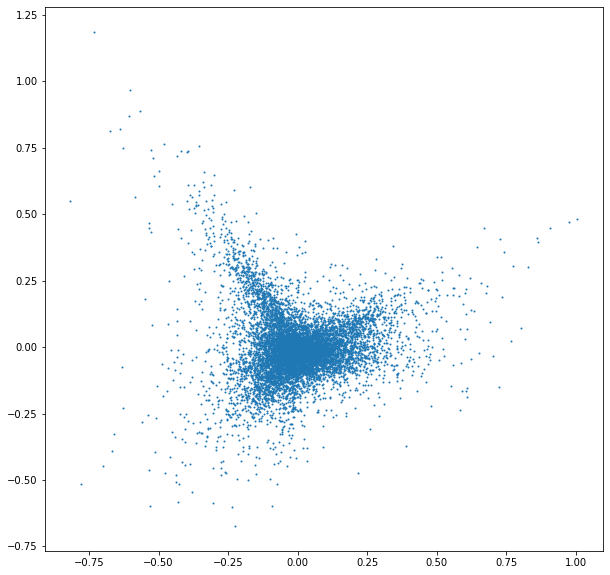

In [105]:
plt.figure(figsize=(10,10))
colors = ["navy", "turquoise", "darkorange"]
lw = 2
plt.scatter(C_r[:,0], C_r[:, 1],s=1, alpha=1)
plt.show()

In [ ]:


from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.3, min_df=2/len(corpus),norm='l2')
tf_idf_matrix  = vectorizer.fit_transform(corpus)

In [ ]:
tf_idf_matrix

## Second Tranform

In [ ]:
featurevec = vectorizer.get_feature_names()

In [ ]:
names = []
parties = []

for rede in reden:
    if rede['name'] not in names:
        names.append(rede['name'])
        parties.append(rede['party'])
        
parlamentarier = []

for count,name in tqdm.tqdm(enumerate(names)):
    hilf = {
        'id':count+1,
        'name': names[count],
        'party': parties[count]
    }
    
    text_lem = []
    for rede in reden:
        if rede['name'] == name:
            rel_lemmata = [ ele.lower() for ex,ele in enumerate(rede['text_lem']) if ele.lower() in featurevec  ]
            text_lem.extend(rel_lemmata)

    hilf.update({'text_lem': text_lem})

    parlamentarier.append(hilf)        
        

In [ ]:
#print(parlamentarier[0]['text_lem'])

In [ ]:


mentionedby = {}
for wort in featurevec:
    #print(wort)
    mentionedby.update({ wort : [] })
    

In [ ]:
if 'kollegin' in featurevec:
    print('ja')

In [ ]:
for parla in parlamentarier:
    for wort in parla['text_lem']: 
        mentionedby[wort].append(parla['name']) 

In [ ]:

    


corpus2=[  mentionedby[wort] for wort in mentionedby   ]

    


In [ ]:
#corpus2[0]

In [ ]:
vectorizer2 = TfidfVectorizer(vocabulary=featurevec,norm='l2')
tf_idf_matrix2  = vectorizer2.fit_transform(corpus2)

In [ ]:
tf_idf_matrix2

## Network

In [ ]:
pairwise_similarity = tf_idf_matrix2.T * tf_idf_matrix2
#pairwise_similarity = tf_idf_matrix * tf_idf_matrix.T
print(len(pairwise_similarity.toarray()))
similarity = pairwise_similarity.toarray()

In [ ]:
nodes = []
featurevec = vectorizer.get_feature_names()
for wx,word in enumerate(featurevec):
    node = {
        'id' : wx,
        'name' : word
    }
    nodes.append(node)
    

graph = {
    'directed': False,
    'graph': 'cooccurr_graph',
    'links': [],
    'nodes': nodes
}

In [ ]:
min_weight = 0.5
for ix,nodeI in tqdm.tqdm(enumerate(graph['nodes'])):
    for jx,nodeJ in enumerate(graph['nodes']):
        if nodeI['id'] < nodeJ['id']:
            source = nodeI['id']
            target = nodeJ['id']
            weight = similarity[ix,jx]
            if weight > min_weight:
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)

In [ ]:
len(graph['links'])

In [ ]:
import networkx as nx

graphforgephi = nx.Graph()
for node in tqdm.tqdm(graph['nodes']):
    graphforgephi.add_node(node['id'],name = node['name']);
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in tqdm.tqdm(graph['links']):   
    graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done')   
nx.write_gexf(graphforgephi, "graphforgephi.gexf")
print('save done')